In [1]:
from time_stitches import *
from step1_functions import *
from features import get_jerk
from functions import *
import os
import warnings
warnings.filterwarnings('ignore')
from step1_functions import smooth
from scipy.signal import butter, filtfilt

In [2]:
def get_path_length_g(time, pos):

    dt = 1/120
    diff_time = np.diff(time, axis=0)
    mask_step_bigger_dt = (diff_time>dt)

    pos_selected = pos[1:][~mask_step_bigger_dt]

    # Calculate the differences in positions between consecutive samples
    differences = np.diff(pos_selected, axis=0)
    # Calculate the Euclidean distance (path length) between consecutive points
    distances = np.linalg.norm(differences, axis=1)
    # Sum up the distances to get the total path length
    total_path_length = np.sum(distances)
    return total_path_length

In [3]:
def compute_v_acc_jerk(data_one_stitch): #data including time and position
    dt = 1/120
    diff_t_x_y_z = np.diff(data_one_stitch, axis = 0)
    mask_step_bigger_dt = (diff_t_x_y_z[:,0]>dt)
    t_x_y_z = diff_t_x_y_z[~mask_step_bigger_dt]
    v_x_y_z = [t_x_y_z[:,1]/t_x_y_z[:,0], t_x_y_z[:,2]/t_x_y_z[:,0], t_x_y_z[:,3]/t_x_y_z[:,0]]
    acc_x_y_z = [v_x_y_z[0]/t_x_y_z[:,0], v_x_y_z[1]/t_x_y_z[:,0], v_x_y_z[2]/t_x_y_z[:,0]]
    jerk_x_x_z = [acc_x_y_z[0]/t_x_y_z[:,0], acc_x_y_z[1]/t_x_y_z[:,0], acc_x_y_z[2]/t_x_y_z[:,0]]
    return v_x_y_z, acc_x_y_z, jerk_x_x_z

In [4]:
def get_mean_std_v(v):
    return np.mean(np.linalg.norm(v, axis=0)), np.std(np.linalg.norm(v, axis=0))

In [5]:
def get_list_idle_time(subject, i, list_np_segmented_nh_rec, list_np_segmented_tw_rec):
    needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')
    tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')
    dict_segment_time = full_segments_time[i]
    
    full_time_segment_tw = pd_2_numpy_and_segment(tweezers_rec, dict_segment_time)
    full_time_segment_nh = pd_2_numpy_and_segment(needle_holder_rec, dict_segment_time)

    list_idle_nh = []
    list_idle_tw = []
    for s in range(8):
        effective_t_nh = list_np_segmented_nh_rec[s][:,0]
        effective_t_tw = list_np_segmented_tw_rec[s][:,0]
        tot_time_nh = full_time_segment_nh[s][:,0]
        tot_time_tw = full_time_segment_tw[s][:,0]
        idle_time_nh = tot_time_nh.shape[0] * (1.0 / 120.0) - effective_t_nh.shape[0] * (1.0 / 120.0)
        idle_time_tw = tot_time_tw.shape[0] * (1.0 / 120.0) - effective_t_tw.shape[0] * (1.0 / 120.0)
        list_idle_nh.append(idle_time_nh)
        list_idle_tw.append(idle_time_tw)
    return list_idle_nh, list_idle_tw


In [6]:
def get_economy_of_volume(segment_pos, PL):
    x = segment_pos[:,0]
    y = segment_pos[:,1]
    z = segment_pos[:,2]

    EOV = ((np.max(x)-np.min(x))*(np.max(y)-np.min(y))*(np.max(z)-np.min(z)))**(1/3)/PL
    return EOV

In [7]:
def get_mean_std_curvature (v, acc):
    v = np.array(v)
    acc = np.array(acc)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        curvature = np.where(v == 0, np.nan, (v * acc) / (v**3))
    return np.nanmean(curvature), np.nanstd(curvature)

In [8]:
def inverse_quaternion(quaternion):
    q1, q2, q3, q4 = quaternion
    inverse = [q1, -q2, -q3, -q4]/(q1**2 + q2**2 +q3**2 +q4**2) #nécessaire si normalisé???
    return inverse

In [9]:
def get_orientation_change(quaternion_nh, quaternion_tw): #SUPPRIMER UNE FOIS QUE L'AUTRE FONCTIONNE
    #compute unitary quaternion
    norm_quaternion_nh =  quaternion_nh/np.linalg.norm(quaternion_nh, axis=0)
    norm_quaternion_tw =  quaternion_tw/np.linalg.norm(quaternion_tw, axis=0)

    #compute inverse (according to wikipedia formula)
    inverse_nh = []
    for i in range (len(norm_quaternion_nh)):
        inverse_nh.append(inverse_quaternion(norm_quaternion_nh[i,:]))
    inverse_tw = []
    for n in range (len(norm_quaternion_tw)):
        inverse_tw.append(inverse_quaternion(norm_quaternion_tw[n,:]))

    #compute rotation difference
    deltaQ_nh = []
    for j in range (len(norm_quaternion_nh)-1):
        q = np.array(norm_quaternion_nh[j])
        qinv = np.array(inverse_nh[j+1])
        deltaQ_nh.append((q*qinv).tolist())
    
    deltaQ_tw = []
    for j in range (len(norm_quaternion_tw)-1):
        q = np.array(norm_quaternion_tw[j])
        qinv = np.array(inverse_tw[j+1])
        deltaQ_tw.append((q*qinv).tolist())

    #compute orientation change
    deltaTeta_nh = []
    for p in range (len(deltaQ_nh)):
        delta_orientation = 2*np.cos(deltaQ_nh[p][0])**(-1)
        deltaTeta_nh.append(delta_orientation)

    deltaTeta_tw = []
    for p in range (len(deltaQ_tw)):
        delta_orientation = 2*np.cos(deltaQ_tw[p][0])**(-1)
        deltaTeta_tw.append(delta_orientation)
    
    return deltaTeta_nh, deltaTeta_tw
    

In [10]:
def get_orientation_change(quaternion):
    #compute unitary quaternion
    norm_quaternion =  quaternion/np.linalg.norm(quaternion, axis=0)
    
    #compute inverse (according to wikipedia formula)
    inverse = []
    for i in range (len(norm_quaternion)):
        inverse.append(inverse_quaternion(norm_quaternion[i,:]))

    #compute rotation difference
    deltaQ = []
    for j in range (len(norm_quaternion)-1):
        q = np.array(norm_quaternion[j])
        qinv = np.array(inverse[j+1])
        deltaQ.append((q*qinv).tolist())

    #compute orientation change
    deltaTeta = []
    for p in range (len(deltaQ)):
        delta_orientation = 2*np.cos(deltaQ[p][0])**(-1)
        deltaTeta.append(delta_orientation)
    
    return deltaTeta
    

In [11]:
def get_angular_displacement(quaternion):
    deltaTeta = get_orientation_change(quaternion)
    angular_disp = np.sum(np.abs(deltaTeta))
    return angular_disp

In [12]:
def get_rate_of_orientation_change(list_np_segmented):
    time = list_np_segmented[:,0]
    quaternion = list_np_segmented[:, 4:8]
    dt = 1/120
    diff_t = np.diff(time, axis = 0)
    mask_step_bigger_dt = (diff_t>dt)
    selected_time = time[1:][~mask_step_bigger_dt]
    selected_quaternion = quaternion[1:][~mask_step_bigger_dt]

    diff_selected_time = np.diff(selected_time, axis = 0)
    deltaTeta = get_orientation_change(selected_quaternion)
    rate_orientation_change = np.mean(np.abs(deltaTeta)/diff_selected_time)

    return rate_orientation_change

In [30]:
def compute_mask_both_tools(subject, i, segment_nh, segment_tw):
    dict_segment_time = full_segments_time[i]
    needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')
    tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')
    ref_nh_time = pd_2_numpy_and_segment(needle_holder_rec, dict_segment_time)[0][0,0]
    ref_tw_time = pd_2_numpy_and_segment(tweezers_rec, dict_segment_time)[0][0,0]

    delta_t = ref_nh_time - ref_tw_time
    time_nh = segment_nh[:,0]
    time_tw = segment_tw[:,0]

    mask_time_nh = np.zeros(len(time_nh))
    for index, t in enumerate(time_nh):
        diff = np.abs(t - np.array(time_tw)) <= (delta_t)
        if (np.sum(diff)>0): mask_time_nh[index]=1

    mask_time_tw = np.zeros(len(time_tw))
    for index, t in enumerate(time_tw):
        diff = np.abs(np.array(time_nh) - t) <= delta_t
        if (np.sum(diff)>0): mask_time_tw[index]=1
    
    return mask_time_nh.astype(int), mask_time_tw.astype(int)

In [43]:
def get_bimanual_dexterity(subject, i, segment_nh, segment_tw):

    v_nh, acc_nh, jerk_nh = compute_v_acc_jerk(segment_nh)
    v_tw, acc_tw, jerk_tw = compute_v_acc_jerk(segment_tw)
    
    mask_nh, mask_tw = compute_mask_both_tools(subject, i, segment_nh, segment_tw)
    
    v_nh_selected = np.array(v_nh).T[mask_nh[1:]] #since with the calculation of the velocity we lose the first value, we take our mask starting from the second value
    v_tw_selected = np.array(v_tw).T[mask_tw[1:]]

    v_stitch_nh = np.linalg.norm(v_nh_selected, axis=0)
    v_stitch_tw = np.linalg.norm(v_tw_selected, axis=0)
        
    mean_v_tw = np.nanmean(v_stitch_tw)
    mean_v_nh = np.nanmean(v_stitch_nh)

    BD = np.sum((v_stitch_nh - mean_v_nh)*(v_stitch_tw - mean_v_tw))/np.sqrt(np.sum((v_stitch_nh - mean_v_nh)**2)*np.sum((v_stitch_tw - mean_v_tw)**2))
    
    return BD

    

In [15]:
def get_bimanual_efficiency(subject, i, stitch, segment_nh, segment_tw): #here consider the whole time task (with selected and unselected moments)
    mask_nh, mask_tw = compute_mask_both_tools(subject, i, segment_nh, segment_tw)
    time_nh = segment_nh[:,0][mask_nh.astype(bool)] #since we have a list we need a boolean mask
    diff_nh = np.diff(time_nh)
    sum_time_nh = np.sum(diff_nh)

    dict_segment_time = full_segments_time[i]
    stitch_string = str(stitch+1) #to match the dictionnary
    begin, end = dict_segment_time[stitch_string]
    diff_time = end-begin

    BE= sum_time_nh/diff_time #sum time is the same for nh and tw

    return BE

In [47]:
def get_bimanual_efficiency2(subject, i, stitch, segment_nh, segment_tw): #consider only time of selected moments
    mask_nh, mask_tw = compute_mask_both_tools(subject, i, segment_nh, segment_tw)
    dt = 1/120
    time_nh = segment_nh[:,0][mask_nh.astype(bool)] #since we have a list we need a boolean mask
    diff_nh = np.diff(time_nh)
    #we don't want to consider the difference of time between 2 points separated by an unselected period
    mask = diff_nh>dt
    diff_nh_ = diff_nh[~mask]
    sum_time_nh = np.sum(diff_nh_)

    time_whole_segment_nh = segment_nh[:,0]
    diff_whole_segment_nh = np.diff(time_whole_segment_nh)
    mask = diff_whole_segment_nh>dt
    diff_ = diff_whole_segment_nh[~mask]
    sum_time_whole = np.sum(diff_)

    if (sum_time_nh ==0): #it is due to imprecision in the algorithm, we should in theory not have 0 values
        BE=np.nan
    else: 
        BE= sum_time_nh/sum_time_whole #sum time is the same for nh and tw

    return BE

In [34]:
subject = 1
i =0
selected_nh,selected_tw = run_step1_per_subject(subject,i)

In [35]:
dict_segment_time = full_segments_time[i]
needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')
tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')
ref_nh = pd_2_numpy_and_segment(needle_holder_rec, dict_segment_time)
ref_tw = pd_2_numpy_and_segment(tweezers_rec, dict_segment_time)
list_np_segmented_tw_rec = pd_2_numpy_and_segment(selected_tw, dict_segment_time)
list_np_segmented_nh_rec = pd_2_numpy_and_segment(selected_nh, dict_segment_time)

In [21]:
list_np_segmented_nh_rec[0][:,0]
np.ones(len(list_np_segmented_nh_rec[0][:,0]))

array([1., 1., 1., ..., 1., 1., 1.])

In [41]:
for s in range (8):
    BE_old = get_bimanual_efficiency(subject, i, s, list_np_segmented_nh_rec[s], list_np_segmented_tw_rec[s])
    BE_new = get_bimanual_efficiency2(subject, i, s, list_np_segmented_nh_rec[s], list_np_segmented_tw_rec[s])
    print(BE_old, BE_new)

0.8536591643539932 0.46446671273896617
0.8016035841313265 0.3408432270730111
0.7204403370481112 0.26636895402237665
0.6607382073954985 0.15999145573000106
0.8348530872774643 0.16964359206519056
0.7266146993318483 0.17967032967032967
0.7034871085120213 0.19642857142857142
0.420991561181435 0.17235123367575095


In [37]:
for s in range (8):
    BD = get_bimanual_dexterity(subject, i, list_np_segmented_nh_rec[s], list_np_segmented_tw_rec[s])
    print(BD)


0.8458873638219253
0.9209998931515259
0.799584945768617
0.8988483718849074
-0.6290457833592283
-0.20047326624754516
0.7145049337015934
0.577759151908522


In [16]:
def butter_lowpass_filter(data, cutoff=12, fs=120, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [17]:
def get_features_simplified(subject_id, i, list_np_segmented_tw_rec, list_np_segmented_nh_rec, save =True):
    # just for the task cluster

    NUMBER_OF_SEGMENTS = 8 

    df_metric = pd.DataFrame(columns=['Tool', 'Stitch','Effective_task_duration', 'Idle_time',  'Path_length', 'Jerk', 'Mean_v', 'Std_v', 'Economy_of_volume',
                                       'Mean_curvature', 'Std_curvature', 'Angular_displacement', 'Rate_of_orientation_change', 'Bimanual_dexterity',
                                       'Bimanual_efficacy'])

    list_idle_nh, list_idle_tw = get_list_idle_time(subject_id, i, list_np_segmented_nh_rec, list_np_segmented_tw_rec)
    for s in range (NUMBER_OF_SEGMENTS):
        t_tw = list_np_segmented_tw_rec[s][:,0]
        t_nh = list_np_segmented_nh_rec[s][:,0]

        idle_t_tw = list_idle_tw[s]
        idle_t_nh = list_idle_nh[s]

        path_length_tw = get_path_length_g(t_tw, list_np_segmented_tw_rec[s][:,1:4])
        path_length_nh = get_path_length_g(t_nh, list_np_segmented_nh_rec[s][:,1:4])

        v_tw, acc_tw, jerk_tw = compute_v_acc_jerk(list_np_segmented_tw_rec[s][:,0:4])
        v_nh, acc_nh, jerk_nh = compute_v_acc_jerk(list_np_segmented_nh_rec[s][:,0:4])

        jerk_approximation_tw = get_jerk(list_np_segmented_tw_rec[s][1:,0], v_tw, acc_tw, jerk_tw) #acc not usefull
        jerk_approximation_nh = get_jerk(list_np_segmented_nh_rec[s][1:,0], v_nh, acc_nh, jerk_nh) #acc not usefull

        mean_v_tw, std_v_tw = get_mean_std_v(v_tw)
        mean_v_nh, std_v_nh = get_mean_std_v(v_nh)

        EOV_nh = get_economy_of_volume(list_np_segmented_nh_rec[s][:,1:4], path_length_nh)
        EOV_tw = get_economy_of_volume(list_np_segmented_tw_rec[s][:,1:4], path_length_tw)

        mean_curvature_nh, std_curvature_nh = get_mean_std_curvature(v_nh, acc_nh)
        mean_curvature_tw, std_curvature_tw = get_mean_std_curvature(v_tw, acc_tw)

        ang_disp_nh= get_angular_displacement(list_np_segmented_nh_rec[s][:, 4:8])
        ang_disp_tw = get_angular_displacement(list_np_segmented_tw_rec[s][:, 4:8])

        rate_orientation_change_nh = get_rate_of_orientation_change(list_np_segmented_nh_rec[s])
        rate_orientation_change_tw = get_rate_of_orientation_change(list_np_segmented_tw_rec[s])
        
        BD = get_bimanual_dexterity(subject_id, i, list_np_segmented_nh_rec[s], list_np_segmented_tw_rec[s])

        BE = get_bimanual_efficiency2(subject, i, s, list_np_segmented_nh_rec[s], list_np_segmented_tw_rec[s])
        
        df_metric.loc[len(df_metric)] = ['TW', s, t_tw.shape[0] * (1.0 / 120.0), idle_t_tw,  path_length_tw, jerk_approximation_tw, mean_v_tw, std_v_tw,
                                          EOV_tw, mean_curvature_tw, std_curvature_tw, ang_disp_tw, rate_orientation_change_tw, BD, BE]
        df_metric.loc[len(df_metric)] = ['NH', s, t_nh.shape[0] * (1.0 / 120.0), idle_t_nh,  path_length_nh, jerk_approximation_nh, mean_v_nh, std_v_nh,
                                          EOV_nh, mean_curvature_nh, std_curvature_nh, ang_disp_nh, rate_orientation_change_nh, BD, BE]

    if save: 
        print('Save')
        directory = f'Features/S_{subject_id}/'
        if not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
        df_metric.to_csv(f'{directory}/df_metrics.csv', index=False)
        return df_metric

    else:
        return df_metric
    

In [48]:
def get_features_simplified_array(subject_id, i, list_np_segmented_tw_rec, list_np_segmented_nh_rec, save =True):
    # just for the task cluster

    NUMBER_OF_SEGMENTS = 8 

    data_metrics = np.zeros((NUMBER_OF_SEGMENTS, 13, 2))
    list_idle_nh, list_idle_tw = get_list_idle_time(subject_id, i, list_np_segmented_nh_rec, list_np_segmented_tw_rec)
    for s in range (NUMBER_OF_SEGMENTS):
        t_tw = list_np_segmented_tw_rec[s][:,0]
        t_nh = list_np_segmented_nh_rec[s][:,0]

        idle_t_tw = list_idle_tw[s]
        idle_t_nh = list_idle_nh[s]

        path_length_tw = get_path_length_g(t_tw, list_np_segmented_tw_rec[s][:,1:4])
        path_length_nh = get_path_length_g(t_nh, list_np_segmented_nh_rec[s][:,1:4])

        v_tw, acc_tw, jerk_tw = compute_v_acc_jerk(list_np_segmented_tw_rec[s][:,0:4])
        v_nh, acc_nh, jerk_nh = compute_v_acc_jerk(list_np_segmented_nh_rec[s][:,0:4])

        jerk_approximation_tw = get_jerk(list_np_segmented_tw_rec[s][1:,0], v_tw, acc_tw, jerk_tw) #acc not usefull
        jerk_approximation_nh = get_jerk(list_np_segmented_nh_rec[s][1:,0], v_nh, acc_nh, jerk_nh) #acc not usefull

        mean_v_tw, std_v_tw = get_mean_std_v(v_tw)
        mean_v_nh, std_v_nh = get_mean_std_v(v_nh)

        EOV_nh = get_economy_of_volume(list_np_segmented_nh_rec[s][:,1:4], path_length_nh)
        EOV_tw = get_economy_of_volume(list_np_segmented_tw_rec[s][:,1:4], path_length_tw)

        mean_curvature_nh, std_curvature_nh = get_mean_std_curvature(v_nh, acc_nh)
        mean_curvature_tw, std_curvature_tw = get_mean_std_curvature(v_tw, acc_tw)

        ang_disp_nh= get_angular_displacement(list_np_segmented_nh_rec[s][:, 4:8])
        ang_disp_tw = get_angular_displacement(list_np_segmented_tw_rec[s][:, 4:8])

        rate_orientation_change_nh = get_rate_of_orientation_change(list_np_segmented_nh_rec[s])
        rate_orientation_change_tw = get_rate_of_orientation_change(list_np_segmented_tw_rec[s])
        
        BD = get_bimanual_dexterity(subject_id, i, list_np_segmented_nh_rec[s], list_np_segmented_tw_rec[s])
        
        BE = get_bimanual_efficiency2(subject, i, s, list_np_segmented_nh_rec[s], list_np_segmented_tw_rec[s])

        data_metrics[s, 0, 0] = t_tw.shape[0] * (1.0 / 120.0)
        data_metrics[s, 0, 1] = t_nh.shape[0] * (1.0 / 120.0)
        data_metrics[s, 1, 0] = idle_t_tw
        data_metrics[s, 1, 1] = idle_t_nh
        data_metrics[s, 2, 0] = path_length_tw
        data_metrics[s, 2, 1] = path_length_nh
        data_metrics[s, 3, 0] = jerk_approximation_tw
        data_metrics[s, 3, 1] = jerk_approximation_nh
        data_metrics[s, 4, 0] = mean_v_tw
        data_metrics[s, 4, 1] = mean_v_nh
        data_metrics[s, 5, 0] = std_v_tw
        data_metrics[s, 5, 1] = std_v_nh
        data_metrics[s, 6, 0] = EOV_tw
        data_metrics[s, 6, 1] = EOV_nh
        data_metrics[s, 7, 0] = mean_curvature_tw
        data_metrics[s, 7, 1] = mean_curvature_nh
        data_metrics[s, 8, 0] = std_curvature_tw
        data_metrics[s, 8, 1] = std_curvature_nh
        data_metrics[s, 9, 0] = ang_disp_tw
        data_metrics[s, 9, 1] = ang_disp_nh
        data_metrics[s, 10, 0] = rate_orientation_change_tw
        data_metrics[s, 10, 1] = rate_orientation_change_nh
        data_metrics[s, 11, 0] = BD
        data_metrics[s, 11, 1] = BD
        data_metrics[s, 12, 0] = BE
        data_metrics[s, 12, 1] = BE

    if save: 
        print('Save')
        directory = f'Features/S_{subject_id}/'
        if not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
        np.save(f"{directory}/ot_metrics.npy", data_metrics)
        return data_metrics

    else:
        return data_metrics
    

In [19]:
subjects=[1,19, 23,7, 24, 26, 10, 13, 16, 17, 20, 27]
i=0
for subject in subjects:
    #select data points corresponding to the main task
    selected_nh,selected_tw = run_step1_per_subject(subject,i)

    #apply filter to coordinates
    selected_nh['X.1'] = butter_lowpass_filter(selected_nh['X.1'], cutoff=12)
    selected_nh['Y.1'] = butter_lowpass_filter(selected_nh['Y.1'], cutoff=12)
    selected_nh['Z.1'] = butter_lowpass_filter(selected_nh['Z.1'], cutoff=12)

    selected_tw['X.1'] = butter_lowpass_filter(selected_tw['X.1'], cutoff=12)
    selected_tw['Y.1'] = butter_lowpass_filter(selected_tw['Y.1'], cutoff=12)
    selected_tw['Z.1'] = butter_lowpass_filter(selected_tw['Z.1'], cutoff=12)

    #cut the time points in stitches
    dict_segment_time = full_segments_time[i]
    list_np_segmented_tw_rec = pd_2_numpy_and_segment(selected_tw, dict_segment_time)
    list_np_segmented_nh_rec = pd_2_numpy_and_segment(selected_nh, dict_segment_time)

    df_metrics = get_features_simplified(subject, i, list_np_segmented_tw_rec, list_np_segmented_nh_rec, save='False')
    print(subject)
    print(df_metrics)
    i=i+1

Save
1
   Tool  Stitch  Effective_task_duration   Idle_time  Path_length       Jerk  \
0    TW       0               238.483333   85.825000     8.336159 -31.280306   
1    NH       0               217.241667  107.058333     4.536104 -31.060091   
2    TW       1               132.166667   87.141667     3.730304 -29.557487   
3    NH       1               133.775000   85.525000     2.431008 -29.540011   
4    TW       2               216.075000  151.833333     4.981386 -30.950042   
5    NH       2               198.858333  169.041667     3.703579 -30.856502   
6    TW       3               149.516667   99.291667     4.199408 -29.779119   
7    NH       3               117.075000  131.725000     2.082637 -28.977462   
8    TW       4               167.433333   62.875000     4.132003 -30.197018   
9    NH       4               151.958333   78.341667     2.616667 -30.028727   
10   TW       5                79.933333   54.775000     2.680974 -27.895020   
11   NH       5                68

In [49]:
subjects=[1,19, 23,7, 24, 26, 10, 13, 16, 17, 20, 27]
i=0
for subject in subjects:
    #select data points corresponding to the main task
    selected_nh,selected_tw = run_step1_per_subject(subject,i)

    #apply filter to coordinates
    selected_nh['X.1'] = butter_lowpass_filter(selected_nh['X.1'], cutoff=12)
    selected_nh['Y.1'] = butter_lowpass_filter(selected_nh['Y.1'], cutoff=12)
    selected_nh['Z.1'] = butter_lowpass_filter(selected_nh['Z.1'], cutoff=12)

    selected_tw['X.1'] = butter_lowpass_filter(selected_tw['X.1'], cutoff=12)
    selected_tw['Y.1'] = butter_lowpass_filter(selected_tw['Y.1'], cutoff=12)
    selected_tw['Z.1'] = butter_lowpass_filter(selected_tw['Z.1'], cutoff=12)

    #cut the time points in stitches
    dict_segment_time = full_segments_time[i]
    list_np_segmented_tw_rec = pd_2_numpy_and_segment(selected_tw, dict_segment_time)
    list_np_segmented_nh_rec = pd_2_numpy_and_segment(selected_nh, dict_segment_time)

    df_metrics = get_features_simplified_array(subject, i, list_np_segmented_tw_rec, list_np_segmented_nh_rec)
    print(subject)
    print(df_metrics)
    i=i+1

Save
1
[[[ 2.38483333e+02  2.17241667e+02]
  [ 8.58250000e+01  1.07058333e+02]
  [ 8.33615941e+00  4.53610438e+00]
  [-3.12803064e+01 -3.10600912e+01]
  [ 3.51440594e-02  2.09103398e-02]
  [ 4.69599992e-02  2.81802085e-02]
  [ 7.39842593e-03  9.06300167e-03]
  [-1.51580993e+05 -6.85349614e+04]
  [ 2.28638544e+07  1.84334893e+07]
  [ 6.01962698e+04  5.44004578e+04]
  [ 1.89183509e+02  1.87639704e+02]
  [-7.06449327e-02 -7.06449327e-02]
  [ 4.64466713e-01  4.64466713e-01]]

 [[ 1.32166667e+02  1.33775000e+02]
  [ 8.71416667e+01  8.55250000e+01]
  [ 3.73030390e+00  2.43100799e+00]
  [-2.95574872e+01 -2.95400106e+01]
  [ 2.86303935e-02  1.83048307e-02]
  [ 4.09558872e-02  1.95659974e-02]
  [ 1.03411396e-02  1.08117230e-02]
  [-1.02514606e+04  4.36846483e+03]
  [ 2.81309694e+06  1.48867316e+06]
  [ 3.35406683e+04  3.34325251e+04]
  [ 1.90290142e+02  1.87325274e+02]
  [-6.92388341e-02 -6.92388341e-02]
  [ 3.40843227e-01  3.40843227e-01]]

 [[ 2.16075000e+02  1.98858333e+02]
  [ 1.51833333e+0

Smoothing signal

In [69]:
subject = 10
i = 6
selected_nh,selected_tw = run_step1_per_subject(subject,i)

In [ ]:
def butter_lowpass_filter(data, cutoff=12, fs=120, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

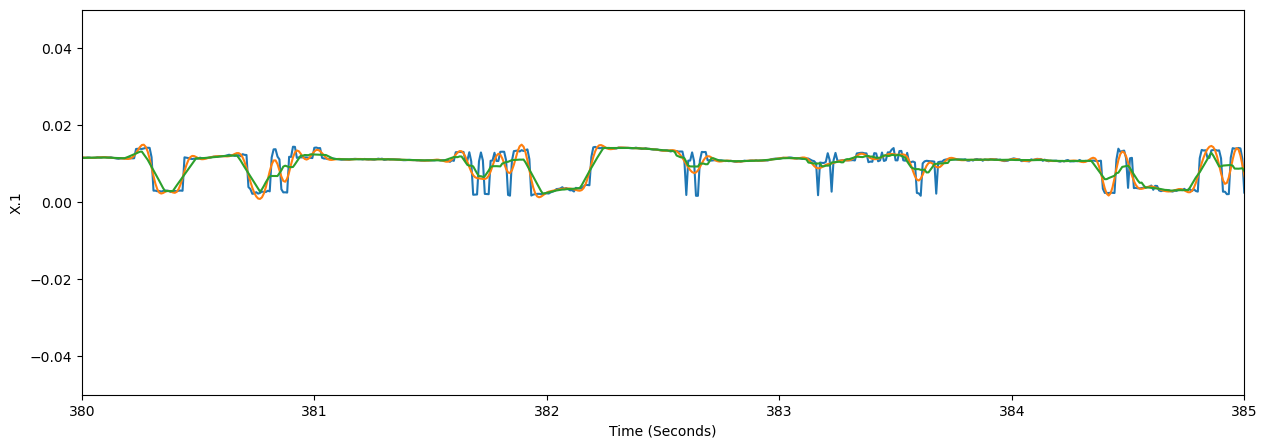

In [74]:
x= selected_nh['X.1']
t = selected_nh['Time (Seconds)']
smooth_x = smooth(x, 12)

fig = plt.figure(figsize=(15, 5))
sns.lineplot(x=selected_nh['Time (Seconds)'], y=selected_nh['X.1'])
sns.lineplot(x=selected_nh['Time (Seconds)'], y=butter_lowpass_filter(selected_nh['X.1']))
sns.lineplot(x=t, y=smooth_x)
plt.xlim(380,385)
plt.ylim(-0.05,0.05)
plt.show()

In [64]:
subjects=[1,19, 23,7, 24, 26, 10, 13, 16, 17, 20, 27]
i=0
for subject in subjects:
    #select data points corresponding to the main task
    selected_nh,selected_tw = run_step1_per_subject(subject,i)

    #apply filter to coordinates
    selected_nh['X.1'] = butter_lowpass_filter(selected_nh['X.1'], cutoff=12)
    selected_nh['Y.1'] = butter_lowpass_filter(selected_nh['Y.1'], cutoff=12)
    selected_nh['Z.1'] = butter_lowpass_filter(selected_nh['Z.1'], cutoff=12)

    selected_tw['X.1'] = butter_lowpass_filter(selected_tw['X.1'], cutoff=12)
    selected_tw['Y.1'] = butter_lowpass_filter(selected_tw['Y.1'], cutoff=12)
    selected_tw['Z.1'] = butter_lowpass_filter(selected_tw['Z.1'], cutoff=12)

    #cut the time points in stitches
    dict_segment_time = full_segments_time[i]
    list_np_segmented_tw_rec = pd_2_numpy_and_segment(selected_tw, dict_segment_time)
    list_np_segmented_nh_rec = pd_2_numpy_and_segment(selected_nh, dict_segment_time)

    df_metrics = get_features_simplified(subject, i, list_np_segmented_tw_rec, list_np_segmented_nh_rec, save = False)
    print(subject)
    print(df_metrics)
    i=i+1

1
   Tool  Stitch  Effective_task_duration   Idle_time  Path_length       Jerk  \
0    TW       0               238.483333   85.825000     8.336159 -31.280306   
1    NH       0               217.241667  107.058333     4.536104 -31.060091   
2    TW       1               132.166667   87.141667     3.730304 -29.557487   
3    NH       1               133.775000   85.525000     2.431008 -29.540011   
4    TW       2               216.075000  151.833333     4.981386 -30.950042   
5    NH       2               198.858333  169.041667     3.703579 -30.856502   
6    TW       3               149.516667   99.291667     4.199408 -29.779119   
7    NH       3               117.075000  131.725000     2.082637 -28.977462   
8    TW       4               167.433333   62.875000     4.132003 -30.197018   
9    NH       4               151.958333   78.341667     2.616667 -30.028727   
10   TW       5                79.933333   54.775000     2.680974 -27.895020   
11   NH       5                68.3083

KeyboardInterrupt: 